In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [12]:
city = Image.open('city.png')
city = np.array(city)

In [13]:
# plt.imshow(city, cmap='gray')

In [14]:
def downsample_image(image, scale_factor):
    
    down_sampled = np.zeros((image.shape[0] // scale_factor, image.shape[1] // scale_factor), dtype=image.dtype)

    for i in range(down_sampled.shape[0]):
        for j in range(down_sampled.shape[1]):
            down_sampled[i, j] = image[i * scale_factor, j * scale_factor]

    return down_sampled

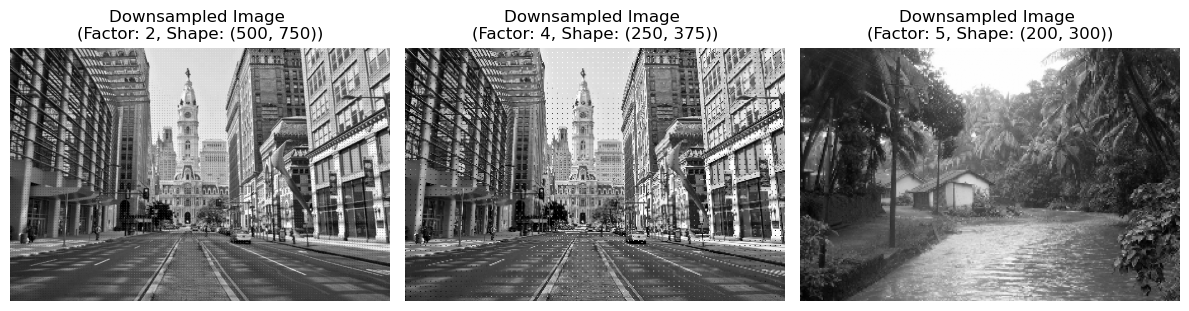

In [15]:
factors = [2,4,5]
plt.figure(figsize=(12, 12))
for factor in factors:
    plt.subplot(1, len(factors), factors.index(factor) + 1)
    downsampled_city = downsample_image(city, factor)
    plt.title(f'Downsampled Image \n(Factor: {factor}, Shape: {downsampled_city.shape})')
    plt.imshow(downsampled_city, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [16]:
def gaussian_filter(kernel_size, sigma):
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

In [ ]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge') # Edge padding is used where pixels at the border are replicated. This is equivalent to OpenCV's BORDER_REPLICATE.
    convolved_image = np.zeros_like(image)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            convolved_image[i, j] = np.sum(region * kernel)

    return convolved_image

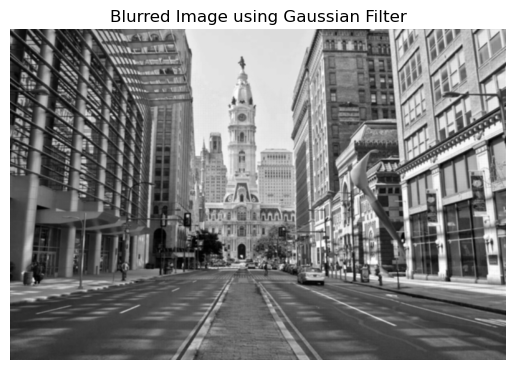

In [18]:
blur_image = convolve2d(city, gaussian_filter(5, 2.0)) # 5x5 kernel with sigma=2.0
plt.imshow(blur_image, cmap='gray') 
plt.title('Blurred Image using Gaussian Filter')
plt.axis('off')
plt.show()

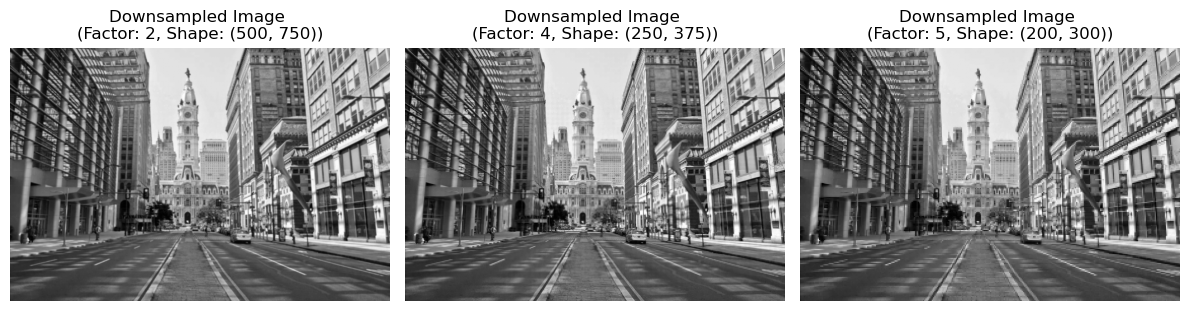

In [19]:
factors = [2,4,5]
plt.figure(figsize=(12, 12))
for factor in factors:
    plt.subplot(1, len(factors), factors.index(factor) + 1)
    downsampled_city = downsample_image(blur_image, factor)
    plt.title(f'Downsampled Image \n(Factor: {factor}, Shape: {downsampled_city.shape})')
    plt.imshow(downsampled_city, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


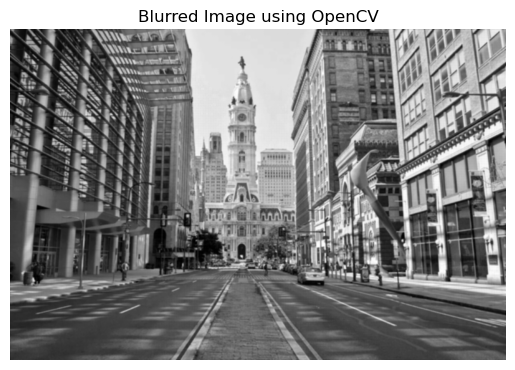

In [45]:
blur_library = cv2.GaussianBlur(city, (5, 5), 2.0, borderType=cv2.BORDER_REPLICATE)
plt.imshow(blur_library, cmap='gray')
plt.title('Blurred Image using OpenCV')
plt.axis('off')
plt.show()

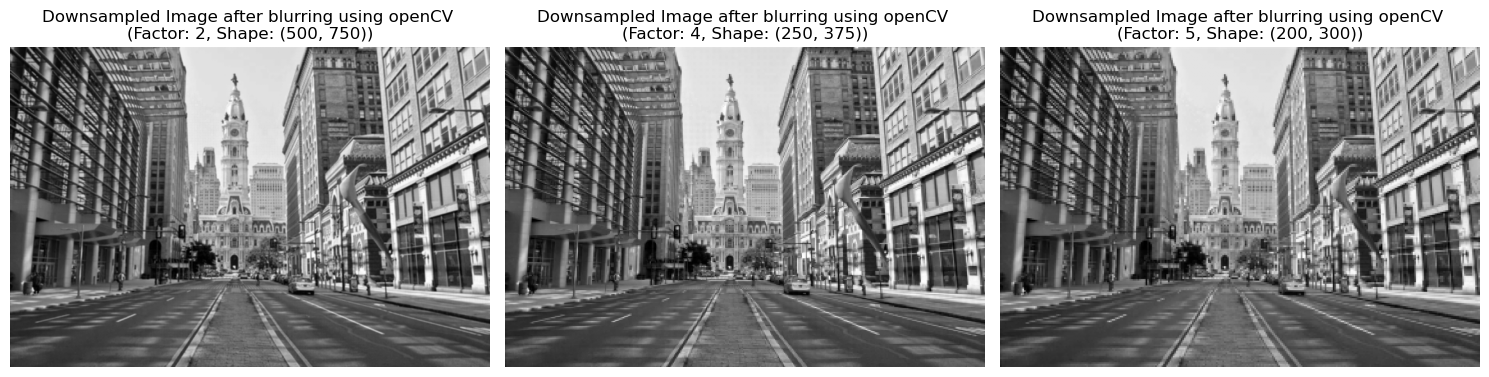

In [46]:
factors = [2,4,5]
plt.figure(figsize=(15, 15))
for factor in factors:
    plt.subplot(1, len(factors), factors.index(factor) + 1)
    downsampled_city = downsample_image(blur_library, factor)
    plt.title(f'Downsampled Image after blurring using openCV \n(Factor: {factor}, Shape: {downsampled_city.shape})')
    plt.imshow(downsampled_city, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [47]:
error = np.sum((downsample_image(blur_image, 5) - downsample_image(blur_library, 5))**2)/np.size((downsample_image(blur_image, 5)))
print(f'Mean Squared Error between the two methods for downsampling factor 5: {error:.4f}')

Mean Squared Error between the two methods for downsampling factor 5: 0.4953


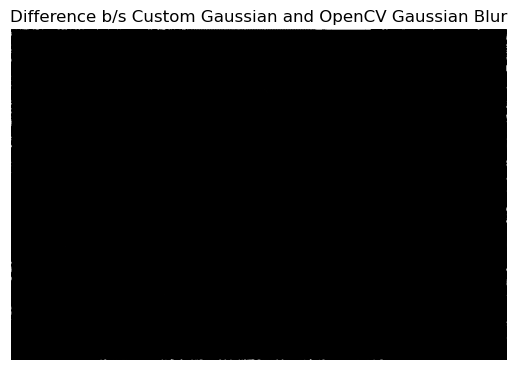

In [43]:
diff = blur_library-blur_image
diff_norm = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
diff_norm[diff_norm >0.5] = 1  # Thresholding small differences to zero for better visualization
plt.imshow(diff_norm*255, cmap='gray')
plt.title('Difference b/s Custom Gaussian and OpenCV Gaussian Blur')
plt.axis('off')
plt.show()

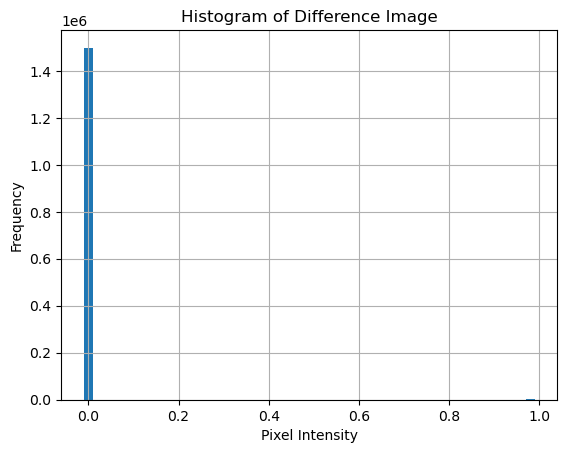

In [44]:
histogram = np.histogram(diff_norm, bins=50, range=(0, 1))
plt.bar(histogram[1][:-1], histogram[0], width=histogram[1][1]-histogram[1][0])
plt.title('Histogram of Difference Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [48]:
window_sizes = [3,4,5]
sigmas = [1.0,1.5,2.0,3.0]
mse = []
for window_size in window_sizes:
    for sigma in sigmas:
        blur_image = convolve2d(city, gaussian_filter(window_size, sigma))
        downsampled_city = downsample_image(blur_image, 5)
        mse.append(np.sum((downsampled_city - downsample_image(blur_library, 5))**2) / np.size(downsampled_city))

Minimum MSE: 0.49533333333333335 at configuration: WS:5, sigma: 2.0


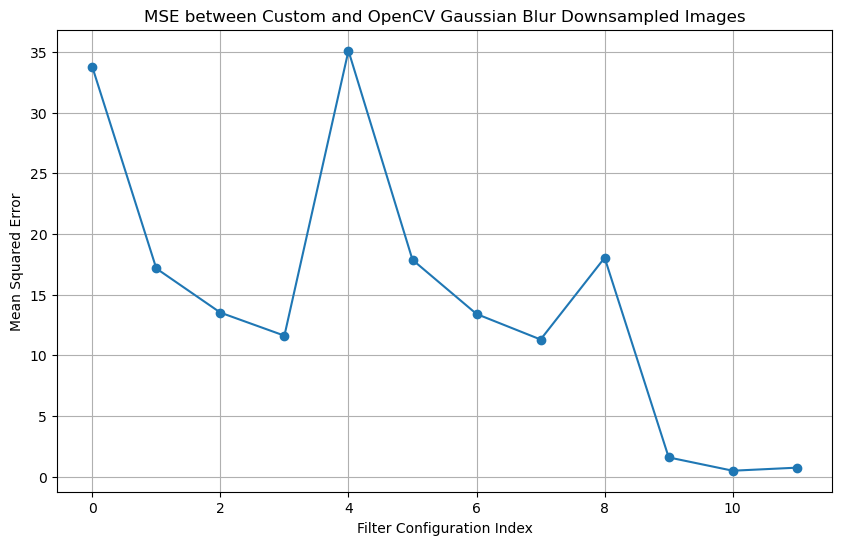

In [49]:
labels = [f'WS:{ws}, sigma: {s}' for ws in window_sizes for s in sigmas]
print(f"Minimum MSE: {min(mse)} at configuration: {labels[mse.index(min(mse))]}")
plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('MSE between Custom and OpenCV Gaussian Blur Downsampled Images')
plt.xlabel('Filter Configuration Index')
plt.ylabel('Mean Squared Error')
# plt.xticks(ticks=range(len(mse)), labels=labels, rotation=45)
plt.grid()
plt.show()


## Edge Detection

In [49]:
checkerboard = Image.open('Checkerboard.png')
coins = Image.open('Coins.png')
main_building = Image.open('MainBuilding.png')
checkerboard = np.array(checkerboard)
coins = np.array(coins)
main_building = np.array(main_building)
print(f"Checkerboard shape: {checkerboard.shape}, Coins shape: {coins.shape}, Main Building shape: {main_building.shape}")

Checkerboard shape: (1200, 1200), Coins shape: (203, 248), Main Building shape: (800, 1200)


### i. Detect edge using gradient based approach

In [50]:
def detect_edges_gradient(image):
    sobel_x = np.array([[ -1, 0, 1], # Sobel operator in x direction. It detects horizontal edges by emphasizing changes in pixel intensity in that direction.
                        [ -2, 0, 2],
                        [ -1, 0, 1]])
    
    sobel_y = np.array([[ 1,  2,  1], # Sobel operator in y direction. It detects vertical edges.
                        [ 0,  0,  0],
                        [-1, -2, -1]])
    
    grad_x = convolve2d(image, sobel_x) # Convolve the image with the Sobel operator in x direction to get the gradient in x direction.
    grad_y = convolve2d(image, sobel_y)
    
    magnitude = np.sqrt(grad_x**2 + grad_y**2) # Compute the gradient magnitude. This gives the strength of the edges at each pixel.
    magnitude = (magnitude / np.max(magnitude)) * 255 # Normalize to the range [0, 255] for display purposes.
    return magnitude.astype(np.uint8)

In [51]:
checkerboard_edges = detect_edges_gradient(checkerboard)
coins_edges = detect_edges_gradient(coins)
main_building_edges = detect_edges_gradient(main_building)


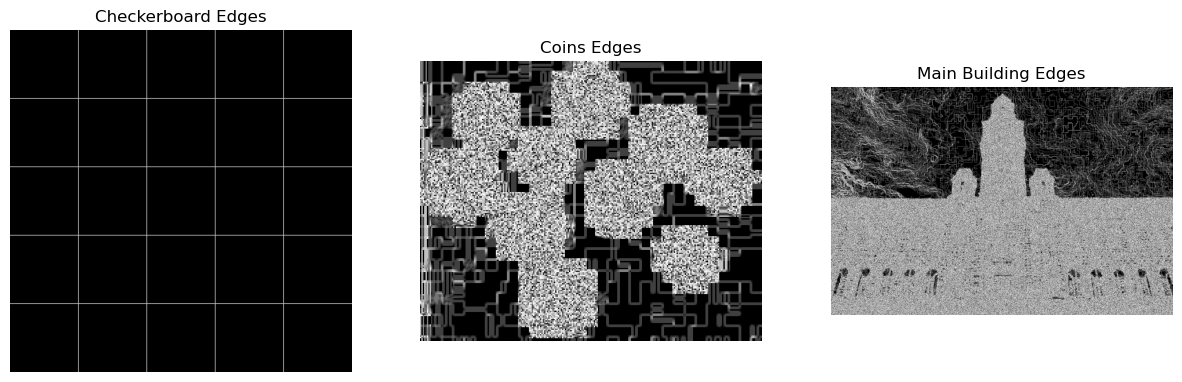

In [52]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(checkerboard_edges, cmap='gray')
plt.title('Checkerboard Edges')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(coins_edges, cmap='gray')
plt.title('Coins Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(main_building_edges, cmap='gray')
plt.title('Main Building Edges')
plt.axis('off')

plt.show()

In [59]:
def laplacian_of_gaussian(image, sigma=1.0):
    # Gaussian for 2D is given by (1/(2πσ^2)) * exp(-(x^2 + y^2)/(2σ^2))
    # Laplacian of Gaussian is given by ((x^2 + y^2 - 2σ^2) / σ^4) * exp(-(x^2 + y^2)/(2σ^2)) / (2πσ^2)
    image = image.astype(float)
    size = int(2 * np.ceil(3 * sigma) + 1)
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    
    term = (xx**2 + yy**2)
    kernel = ((term - 2 * sigma**2) / sigma**4) * np.exp(-term / (2 * sigma**2))
    kernel /= (2 * np.pi * sigma**2)
    kernel -= np.mean(kernel)
    
    return convolve2d(image, kernel)

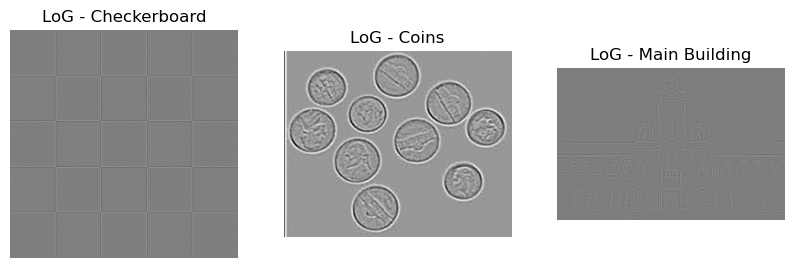

In [61]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
log_checkerboard = laplacian_of_gaussian(checkerboard, sigma=1.0)
plt.imshow(log_checkerboard, cmap='gray')
plt.title('LoG - Checkerboard') 
plt.axis('off')
plt.subplot(1, 3, 2)
log_coins = laplacian_of_gaussian(coins, sigma=1.0)
plt.imshow(log_coins, cmap='gray')
plt.title('LoG - Coins')
plt.axis('off')
plt.subplot(1, 3, 3)
log_main_building = laplacian_of_gaussian(main_building, sigma=1.0)
plt.imshow(log_main_building, cmap='gray')
plt.title('LoG - Main Building')
plt.axis('off')
plt.show()

In [63]:
#Gaussian noise
def add_gaussian_noise(image, mean, stddev):
    noise = np.random.normal(mean, stddev, image.shape) # Generate Gaussian noise with specified mean and standard deviation.
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255) 
    return noisy_image.astype(np.uint8)

In [70]:
noisy_main_building = add_gaussian_noise(main_building, mean=0, stddev=25)
noisy_coins = add_gaussian_noise(coins, mean=0, stddev=25)
noisy_checkerboard = add_gaussian_noise(checkerboard, mean=0, stddev=25)

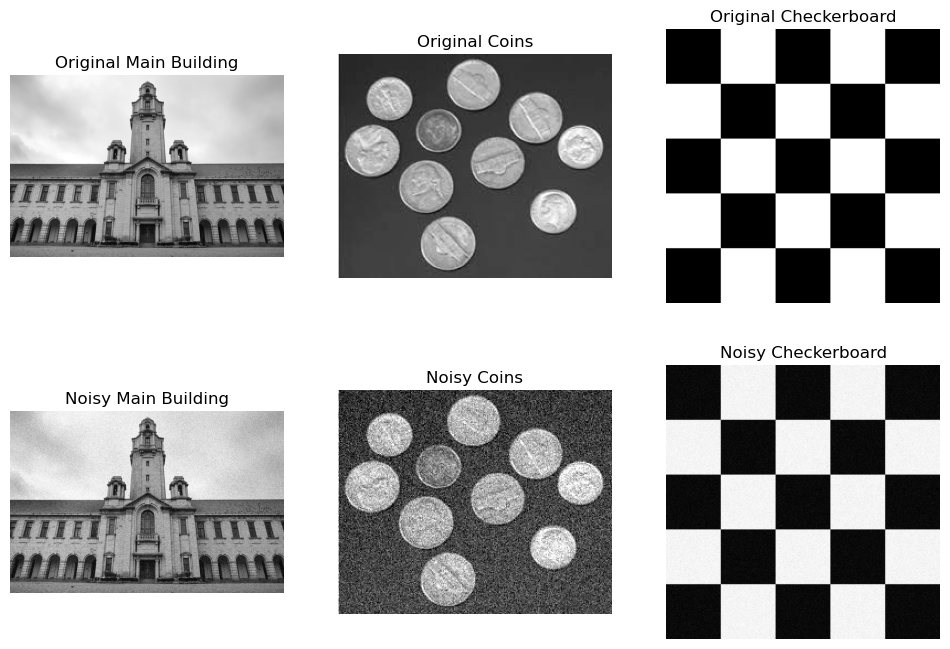

In [71]:
#Plot together original and noisy images
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(main_building, cmap='gray')
plt.title('Original Main Building')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(noisy_main_building, cmap='gray')
plt.title('Noisy Main Building')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(coins, cmap='gray')  
plt.title('Original Coins')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(noisy_coins, cmap='gray')
plt.title('Noisy Coins')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(checkerboard, cmap='gray')
plt.title('Original Checkerboard')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(noisy_checkerboard, cmap='gray')
plt.title('Noisy Checkerboard')
plt.axis('off')
# plt.tight_layout()
plt.show()

In [ ]:
gaussian_smoothed_main_building = convolve2d(noisy_main_building, gaussian_filter(7, 3.0)) # Apply Gaussian smoothing with a 7x7 kernel and sigma of 3.0. 
gaussian_smoothed_coins = convolve2d(noisy_coins, gaussian_filter(7, 3.0))
gaussian_smoothed_checkerboard = convolve2d(noisy_checkerboard, gaussian_filter(7, 3.0))

In [73]:
edge_gaussian_main_building = detect_edges_gradient(gaussian_smoothed_main_building)
edge_gaussian_coins = detect_edges_gradient(gaussian_smoothed_coins)
edge_gaussian_checkerboard = detect_edges_gradient(gaussian_smoothed_checkerboard)

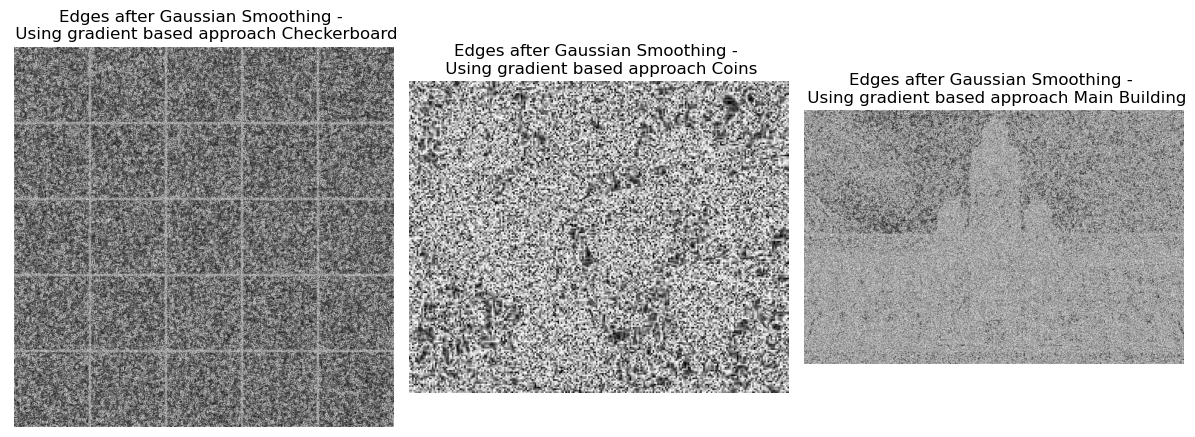

In [88]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.imshow(edge_gaussian_checkerboard, cmap='gray')
plt.title('Edges after Gaussian Smoothing - \n Using gradient based approach Checkerboard')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(edge_gaussian_coins, cmap='gray')
plt.title('Edges after Gaussian Smoothing - \n Using gradient based approach Coins')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(edge_gaussian_main_building, cmap='gray')
plt.title('Edges after Gaussian Smoothing - \n Using gradient based approach Main Building')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
edge_lp_checkerboard = laplacian_of_gaussian(noisy_checkerboard, sigma=1.0) # Apply Laplacian of Gaussian edge detection on noisy checkerboard image with sigma 1.0
edge_lp_coins = laplacian_of_gaussian(noisy_coins, sigma=1.0)
edge_lp_main_building = laplacian_of_gaussian(noisy_main_building, sigma=1.0)

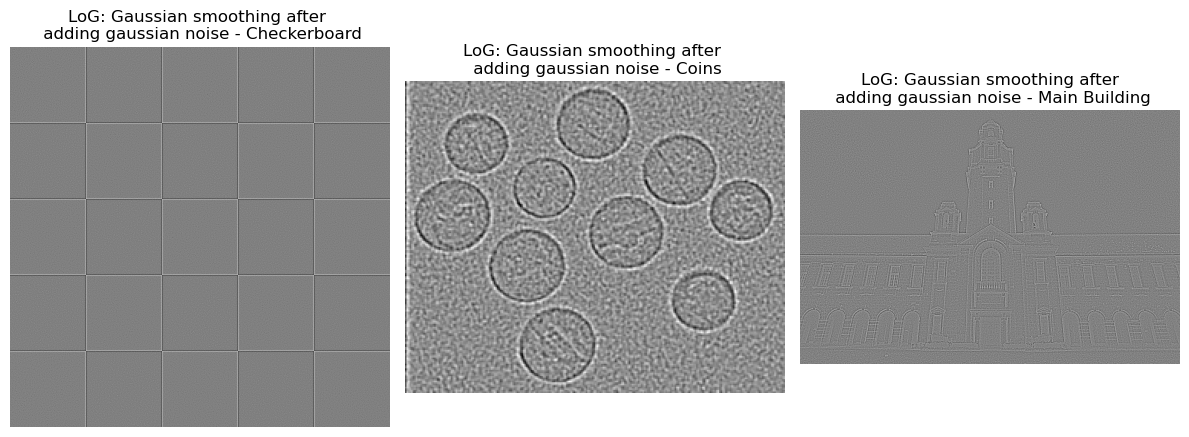

In [95]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.imshow(edge_lp_checkerboard, cmap='gray')
plt.title('LoG: Gaussian smoothing after \n adding gaussian noise - Checkerboard')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(edge_lp_coins, cmap='gray')
plt.title('LoG: Gaussian smoothing after \n adding gaussian noise - Coins')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(edge_lp_main_building, cmap='gray')
plt.title('LoG: Gaussian smoothing after\n adding gaussian noise - Main Building')
plt.axis('off')
plt.tight_layout()
plt.show()
